# 1 - Importando Bibliotecas e recursos

In [4]:
#Pacotes e recursos
!pip install fastparquet Unidecode seaborn nltk scikit-learn wordcloud transformers datasets xgboost==0.90


In [5]:
import pandas as pd
import fastparquet

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from string import punctuation
from nltk import tokenize, ngrams
import unidecode
import numpy as np
import re
import os
import shutil

# Sklearn
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB

import xgboost as xgb

from wordcloud import WordCloud
import matplotlib.pyplot as plt

#---------- Recursos ----------#
nltk.download('stopwords')
nltk.download('rslp')
nltk.download('punkt')


#---------- Transformers ----------#
from datasets import Dataset
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding
import tensorflow as tf


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 1.1 - Introdução as váriaveis do problema

Resumo das variáveis:  

<b>submission_date</b> - Data / hora da submissão da avaliação. De Janeiro/18 a Maio/18. Não possui dados nulos.  
<b>reviewer_id</b> - Id do avaliador. Pode avaliar diferentes produtos em diferentes momentos. Pode avaliar diferentes produtos no mesmo momento.    
<b>product_id</b> - Id do produto avaliado.  
<b>product_name</b> - Nome do produto.  
<b>product_brand</b> - Marca do produto.  
<b>site_category_lv1</b> - Categoria do site.  
<b>site_category_lv2</b> - Categoria do site nível 2.  
<b>review_title</b> - Título da avaliação. Existem alguns casos incoerentes como Título 'Bom' e nota baixa. Podem atrapalhar na modelagem.    
<b>overall_rating</b> - Nota. Teremos problemas com desbalanceamento.      
<b>recommend_to_a_friend</b> - Recomendou para um amigo? Pode ser utilizada para reforçar ainda mais a classificação como positiva (?).    
<b>review_text</b> - Texto da avaliação.    
<b>reviewer_birth_year</b> - Ano de nascimento do avaliador.  
<b>reviewer_gender</b> - Gênero do avaliador.  
<b>reviewer_state</b> - Estado do avaliador.  


# 2 -  Carregamento dos dados, limpeza e tratamento

In [6]:
df = pd.read_parquet('./B2W-Reviews01.parquet')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132373 entries, 0 to 132372
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   submission_date        132373 non-null  object 
 1   reviewer_id            132373 non-null  object 
 2   product_id             132373 non-null  object 
 3   product_name           132289 non-null  object 
 4   product_brand          40982 non-null   object 
 5   site_category_lv1      132367 non-null  object 
 6   site_category_lv2      128360 non-null  object 
 7   review_title           132071 non-null  object 
 8   overall_rating         132373 non-null  int64  
 9   recommend_to_a_friend  132355 non-null  object 
 10  review_text            129098 non-null  object 
 11  reviewer_birth_year    126389 non-null  float64
 12  reviewer_gender        128237 non-null  object 
 13  reviewer_state         128382 non-null  object 
dtypes: float64(1), int64(1), object(12)


In [8]:
df.describe()

,overall_rating,reviewer_birth_year
count,132373.000000,126389.000000
mean,3.492004,1977.495898
std,1.530289,21.895265
min,1.000000,59.000000
25%,2.000000,1969.000000
50%,4.000000,1980.000000
75%,5.000000,1987.000000
max,5.000000,2018.000000


## 2.1 Tratamento de Nulos

In [9]:
df.isna().sum()

submission_date              0
reviewer_id                  0
product_id                   0
product_name                84
product_brand            91391
site_category_lv1            6
site_category_lv2         4013
review_title               302
overall_rating               0
recommend_to_a_friend       18
review_text               3275
reviewer_birth_year       5984
reviewer_gender           4136
reviewer_state            3991
dtype: int64

In [10]:
df = df.dropna(subset=['review_text'])
df = df.reset_index(drop=True)

# Removendo coluna nula e valores vazios
df.drop('product_brand', axis = 1, inplace=True)
df.dropna(inplace=True)

## 2.2 Remoção de Duplicadas

In [11]:
df.duplicated().value_counts()

False    118515
True        792
dtype: int64

In [12]:
# Exemplo de duplicada
duplicadas = df.duplicated()
df[df['submission_date']=='2018-01-10 07:05:00']

,submission_date,reviewer_id,product_id,product_name,site_category_lv1,site_category_lv2,review_title,overall_rating,recommend_to_a_friend,review_text,reviewer_birth_year,reviewer_gender,reviewer_state
12184,2018-01-10 07:05:00,b8d23d502c96dbdcc6e9bca62182ef54288f947a61daa0...,18913368,Chapinha Prancha Profissional Nano Titanium 1 ...,Beleza e Perfumaria,Cabelo,adorei o produto,5,Yes,"muito bom, recomendo. Atingiu minhas expectati...",1995.0,F,RJ
12185,2018-01-10 07:05:00,b8d23d502c96dbdcc6e9bca62182ef54288f947a61daa0...,18913368,Chapinha Prancha Profissional Nano Titanium 1 ...,Beleza e Perfumaria,Cabelo,adorei o produto,5,Yes,"muito bom, recomendo. Atingiu minhas expectati...",1995.0,F,RJ


In [13]:
#Dropando duplicadas
df = df.drop_duplicates()
df = df.reset_index(drop=True)

## 2.3 Variáveis

In [14]:
# Início e Final da data do comentário
df.submission_date.min(), df.submission_date.max()

('2018-01-01 00:11:28', '2018-05-31 23:50:33')

In [15]:
# Analise de User
pd.DataFrame(df['reviewer_id'].value_counts().head())

,reviewer_id
6ca0a1b3fa3b50ffa21e61a01633fd785172ebb04268d1ec97c7c958608902ea,107
e34a8ba82a47141e5b2d7fbb53e8b7a7f4222ee64d27d2d4f5e4bf245a0fd4be,59
684f91f286b491be17ebf2deb31e8e58feb3885cdcc5c7ee47e807eaec4f1eaf,41
a9cacfd104888c71bb879c31c5c3288d234ea693367379dbe9b58e7032a60d04,26
7995080e19b950dbe58403ab320dab0e5851d6346e6ed240c280905687394e55,20


In [16]:
# Analise de Produto
df['product_id'].value_counts().head()

132444092    750
126474851    733
128010777    638
132444050    520
129543938    490
Name: product_id, dtype: int64

## 2.4 Análise de Notas

In [17]:
# Títulos mais frequentes e nota 1
df[df['overall_rating']==1]['review_title'].value_counts().index[:15]

Index(['Não recebi o produto', 'Péssimo', 'Não gostei', 'Não recebi', 'Ruim',
       'Produto com defeito', 'Não gostei do produto', 'Propaganda enganosa',
       'Péssima qualidade', 'Pessimo', 'Não funciona', 'Não recomendo',
       'Péssimo produto', 'NÃO RECEBI O PRODUTO', 'Horrível'],
      dtype='object')

In [18]:
# Titulos mais frequêntes e nota 2
df[df['overall_rating']==2]['review_title'].value_counts().index[:15]

Index(['Regular', 'Não gostei', 'regular', 'Não recomendo',
       'Não gostei do produto', 'Razoável', 'Bom', 'Mais ou menos',
       'Produto regular', 'Não recebi o produto', 'Ruim',
       'Produto com defeito', 'Defeito', 'Fraco', 'Decepção'],
      dtype='object')

In [19]:
# Titulos mais frequêntes e nota 3
df[df['overall_rating']==3]['review_title'].value_counts().index[:15]

Index(['Bom', 'Gostei', 'Bom produto', 'Gostei do produto', 'bom',
       'Produto bom', 'Muito bom', 'Recomendo', 'gostei', 'gostei do produto',
       'Gostei muito do produto', 'bom produto', 'Gostei do produto.',
       'Bom custo benefício', 'produto bom'],
      dtype='object')

In [20]:
# Titulos mais frequêntes e nota 4
df[df['overall_rating']==4]['review_title'].value_counts().index[:15]

Index(['Muito bom', 'Ótimo produto', 'Ótimo', 'Gostei muito do produto',
       'Gostei do produto', 'Gostei', 'Recomendo', 'Gostei muito', 'muito bom',
       'Bom', 'Gostei muito do produto!', 'Bom produto', 'Muito bom!',
       'Produto muito bom', 'Excelente'],
      dtype='object')

In [21]:
# Titulos mais frequêntes e nota 5
df[df['overall_rating']==5]['review_title'].value_counts().index[:15]

Index(['Excelente', 'Muito bom', 'Ótimo produto', 'Ótimo', 'Excelente produto',
       'Gostei muito do produto', 'Gostei muito do produto!', 'Perfeito',
       'Produto excelente', 'Recomendo', 'Maravilhoso', 'excelente',
       'muito bom', 'Excelente!', 'Gostei muito'],
      dtype='object')

In [22]:
# Analisando casos incoerentes com título 'Bom' e nota baixa. Dropado
df[(df['overall_rating']==2)&(df['review_title']=='Bom')].shape

df[(df['overall_rating']==2)&(df['review_title']=='Bom')]['review_text'].values[:5]

#Dropando valores incoerentes
df = df.drop(df[(df['overall_rating'] == 2) & (df['review_title'] == 'Bom')].index)
df = df.reset_index(drop=True)

# 3 - EDA

Criando coluna 'review_id' para usar de indice

In [23]:
df['review_id'] = df.index
df.head(2)

,submission_date,reviewer_id,product_id,product_name,site_category_lv1,site_category_lv2,review_title,overall_rating,recommend_to_a_friend,review_text,reviewer_birth_year,reviewer_gender,reviewer_state,review_id
0,2018-01-01 00:11:28,d0fb1ca69422530334178f5c8624aa7a99da47907c44de...,132532965,Notebook Asus Vivobook Max X541NA-GO472T Intel...,Informática,Notebook,Bom,4,Yes,Estou contente com a compra entrega rápida o ú...,1958.0,F,RJ,0
1,2018-01-01 00:13:48,014d6dc5a10aed1ff1e6f349fb2b059a2d3de511c7538a...,22562178,Copo Acrílico Com Canudo 500ml Rocie,Utilidades Domésticas,"Copos, Taças e Canecas","Preço imbatível, ótima qualidade",4,Yes,"Por apenas R$1994.20,eu consegui comprar esse ...",1996.0,M,SC,1


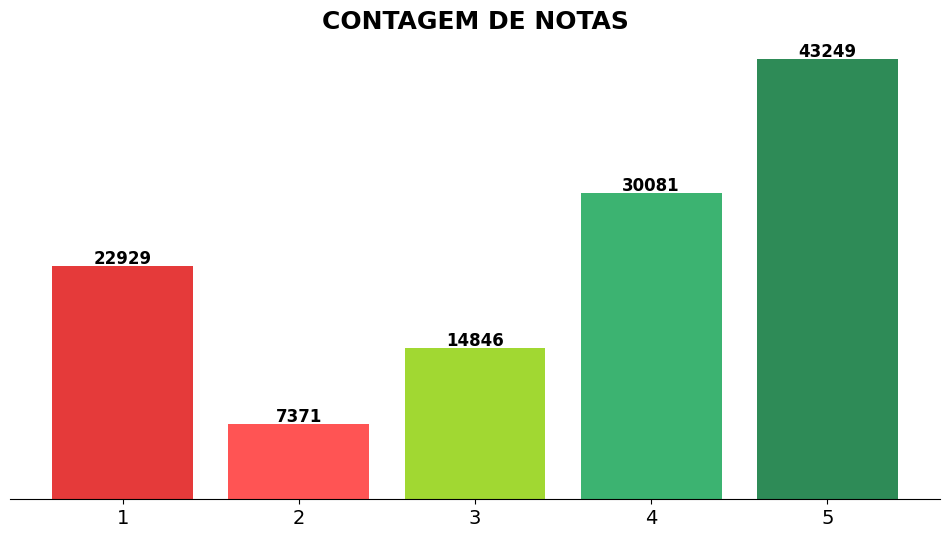

In [24]:
fig, ax = plt.subplots(figsize=(12, 6))

colors = ['#e53a3a', '#ff5454', '#a1d832', '#3CB371', '#2E8B57']
categories = sorted(df['overall_rating'].unique())

for i, category in enumerate(categories):
    count = df['overall_rating'].value_counts().loc[category]
    ax.bar(category, count, color=colors[i])

for p, category in zip(ax.patches, categories):
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points',
                fontsize=12, fontweight='bold', color='black')

sns.despine()
ax.set_title('CONTAGEM DE NOTAS', fontsize=18, fontweight='bold', color='black')
ax.yaxis.set_ticks([])
plt.ylabel('')
plt.xlabel('')

ax.spines['left'].set_visible(False)
ax.tick_params(axis='x', colors='black', labelsize=14)
ax.spines['bottom'].set_color('black')
ax.set_facecolor('none')

fig.patch.set_facecolor('none')

plt.show()


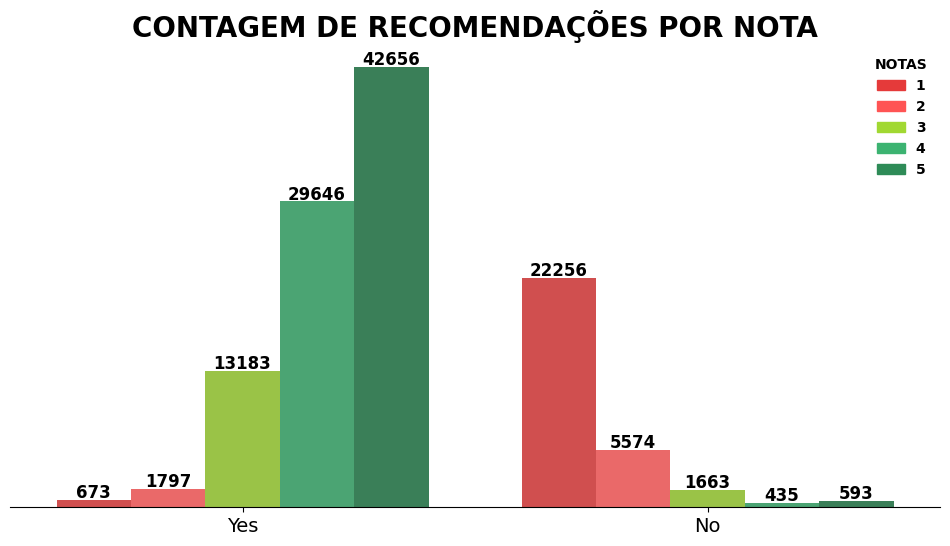

In [25]:
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.countplot(data=df, x='recommend_to_a_friend', hue='overall_rating', palette=colors)


for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points',
               fontsize=12, fontweight='bold',color='black')

sns.despine()
ax.yaxis.set_ticks([])
plt.ylabel('')
plt.xlabel('')
ax.set_title('CONTAGEM DE RECOMENDAÇÕES POR NOTA', fontsize=20, fontweight='bold',color= 'black')


legend_labels = ['1', '2', '3', '4', '5']
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
legend = ax.legend(legend_handles, legend_labels, loc='upper right', title='NOTAS',framealpha=0.0)
legend.get_title().set_fontweight('bold')
legend.get_title().set_color('black')
for text in legend.get_texts():
    text.set_fontweight('bold')
    text.set_color('black')



ax.spines['left'].set_visible(False)
ax.tick_params(axis='x', colors='black',labelsize=14)
ax.spines['bottom'].set_color('black')
ax.set_facecolor('none')
fig.patch.set_facecolor('none')
ax.title.set_y(1.08)

plt.show()

## 3.1 -  Nuvem de Palavras

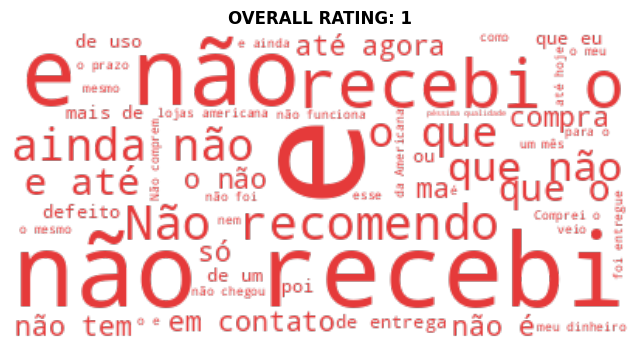

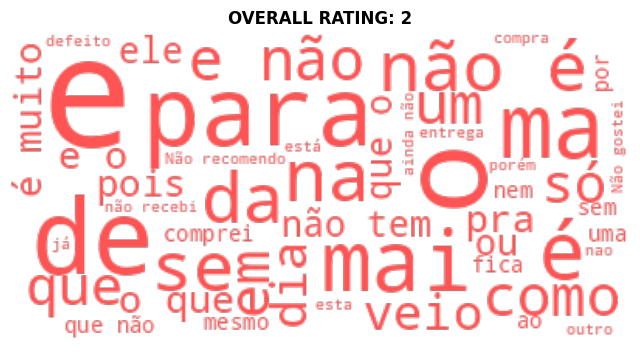

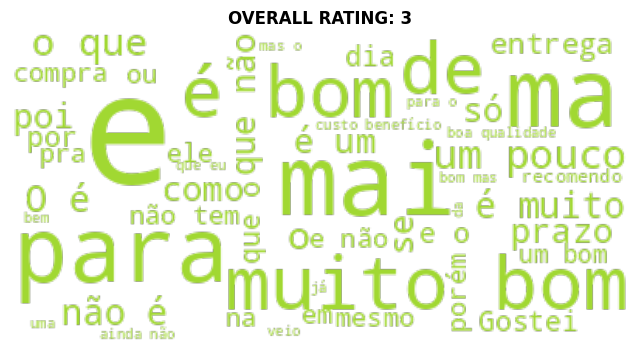

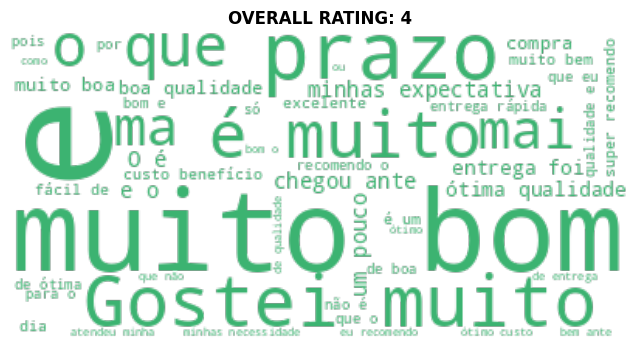

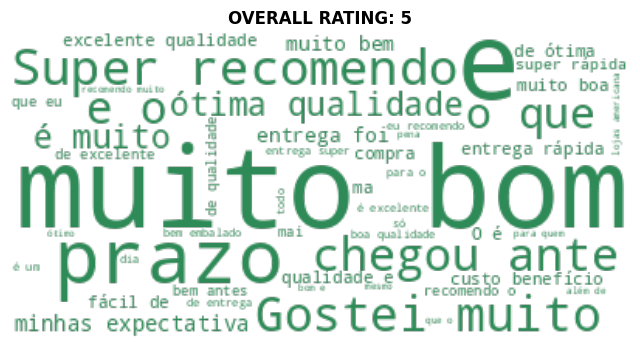

In [26]:
def remove_word(text, word):
    # Substitui todas as ocorrências da palavra, independentemente da capitalização
    return re.sub(r'\b{}\b'.format(re.escape(word)), '', text, flags=re.IGNORECASE)

def plot_wordcloud(text, title, color):
    if os.path.isfile('.arial.ttf'):
        wordcloud = WordCloud(width=800, height=400, max_font_size=150, background_color='white',
                              prefer_horizontal=0.9, max_words=50, font_path='./arial.ttf').generate(text)
    else:
        wordcloud = WordCloud(width=400, height=200, max_font_size=100, background_color=None,
                              mode='RGBA', prefer_horizontal=0.9, max_words=50,
                              color_func=lambda *args, **kwargs: color).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'OVERALL RATING: {title}', color='black', fontweight='bold')

overall_ratings = [1, 2, 3, 4, 5]
colors = ['#e53a3a', '#ff5454', '#a1d832', '#3CB371', '#2E8B57']

for rating, color in zip(overall_ratings, colors):
    text = ' '.join(df[df['overall_rating'] == rating]['review_text'].astype(str))
    text = remove_word(text, 'produto')

    fig = plt.figure(figsize=(8, 5))
    plot_wordcloud(text, rating, color)
    fig.patch.set_facecolor('none')
    plt.show()

# 4 - Tratamento do texto

In [27]:
def tratar(df, coluna):

  palavras_irrelevantes = nltk.corpus.stopwords.words("portuguese")
  pontuacao = []
  for ponto in punctuation:
    pontuacao.append(ponto)
  pontuacao_stopwords = pontuacao + palavras_irrelevantes
  token_pontuacao = tokenize.WordPunctTokenizer()
  sem_acentos = [unidecode.unidecode(texto) for texto in df[coluna]]
  stopwords_sem_acentos = [unidecode.unidecode(texto) for texto in pontuacao_stopwords]
  stemmer = nltk.RSLPStemmer()

  df['texto_tratado'] = sem_acentos

  frase_processada = []

  for texto in df['texto_tratado']:

    nova_frase = []
    texto = texto.lower()
    texto = texto.replace('http','')
    texto = texto.replace('...','')
    texto = texto.replace('://','')
    texto = texto.replace('..','')
    texto = re.sub('\d','', texto)
    palavras_texto = token_pontuacao.tokenize(texto)
    for palavra in palavras_texto:
        if palavra not in pontuacao_stopwords:
            nova_frase.append(stemmer.stem(palavra))
    frase_processada.append(' '.join(nova_frase))

  df['texto_tratado'] = frase_processada

In [28]:
tratar(df,'review_text')

In [29]:
#df[['review_text','texto_tratado','polarity', 'real_review', 'overall_rating']]

# 5 -  Baseline Multiclasse

In [30]:
# Abordagem de Rating
var='overall_rating'
X = df['texto_tratado']
y = df[var]

In [31]:
# Separação dos conjuntos de Teste, Treino e Validação
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [32]:
def model_test_grid_search(max_df = 1.0, ngram_range = (1,1)):
    vectorizer = TfidfVectorizer(max_df = max_df, ngram_range = ngram_range, max_features = 1000)
    X_train_tfidf = vectorizer.fit_transform(X_train)

    classifier = LogisticRegression(max_iter = 500)
    classifier.fit(X_train_tfidf, y_train)

    X_val_tfidf = vectorizer.transform(X_val)

    y_pred = classifier.predict(X_val_tfidf)

    print('#------------------------------------------------------------#')
    print(f'Parameters max_df = {max_df}, ngram = {ngram_range}')
    b_accuracy = balanced_accuracy_score(y_val, y_pred)
    print('#------------------------------------------------------------#')
    print("Balanced Accuracy:", b_accuracy)
    print('#------------------------------------------------------------#')
    accuracy = accuracy_score(y_val, y_pred)
    print("Accuracy:", accuracy)
    print('#------------------------------------------------------------#')
    print(classification_report(y_val, y_pred))
    print('#------------------------------------------------------------#')

    return((max_df, ngram_range, b_accuracy))

In [33]:
print('Resultado do Baseline do Modelo')
print('#------------------------------------------------------------#')
print('Modelo TF-IDF Simples seguido de Logistic Regression Simples')
model_test_grid_search()

Resultado do Baseline do Modelo
#------------------------------------------------------------#
Modelo TF-IDF Simples seguido de Logistic Regression Simples
#------------------------------------------------------------#
Parameters max_df = 1.0, ngram = (1, 1)
#------------------------------------------------------------#
Balanced Accuracy: 0.47799103701709045
#------------------------------------------------------------#
Accuracy: 0.5736969824857565
#------------------------------------------------------------#
              precision    recall  f1-score   support

           1       0.70      0.88      0.78      3713
           2       0.35      0.15      0.21      1221
           3       0.39      0.26      0.31      2370
           4       0.45      0.35      0.39      4841
           5       0.61      0.75      0.67      6811

    accuracy                           0.57     18956
   macro avg       0.50      0.48      0.47     18956
weighted avg       0.54      0.57      0.55     18

(1.0, (1, 1), 0.47799103701709045)

In [34]:
def plot_confusion_matrix(confusion_matrix):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Matriz de Confusão')
    plt.xlabel('Classe Prevista')
    plt.ylabel('Classe Real')
    plt.show()

## 5.1 - Melhorando o TF-IDF do Baseline Multiclasse

In [36]:
results = []

In [37]:
ngram_range = [(1,1), (1,2), (1,3)]
max_df = [0.3 ,0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [38]:
# Grid Search Manual
for max_df_ in max_df:
    for ngram in ngram_range:
        results.append(model_test_grid_search(max_df_, ngram))

#------------------------------------------------------------#
Parameters max_df = 0.3, ngram = (1, 1)
#------------------------------------------------------------#
Balanced Accuracy: 0.47327197477514016
#------------------------------------------------------------#
Accuracy: 0.5696349440810298
#------------------------------------------------------------#
              precision    recall  f1-score   support

           1       0.70      0.87      0.78      3713
           2       0.35      0.14      0.20      1221
           3       0.39      0.26      0.31      2370
           4       0.44      0.34      0.39      4841
           5       0.60      0.75      0.67      6811

    accuracy                           0.57     18956
   macro avg       0.50      0.47      0.47     18956
weighted avg       0.54      0.57      0.54     18956

#------------------------------------------------------------#
#------------------------------------------------------------#
Parameters max_df = 0.3, 

In [39]:
df_results = pd.DataFrame(results, columns= ['Max_df', 'ngram', 'Balanced Acc'])

In [40]:
df_results.sort_values(['Balanced Acc', 'Max_df', 'ngram'], ascending=False)

,Max_df,ngram,Balanced Acc
20,0.9,"(1, 3)",0.483855
17,0.8,"(1, 3)",0.483855
14,0.7,"(1, 3)",0.483855
11,0.6,"(1, 3)",0.483855
8,0.5,"(1, 3)",0.483855
5,0.4,"(1, 3)",0.483855
4,0.4,"(1, 2)",0.483441
19,0.9,"(1, 2)",0.482968
16,0.8,"(1, 2)",0.482968
13,0.7,"(1, 2)",0.482968


## 5.2 - Resultado do Modelo com TF-IDF melhorado

In [41]:
vectorizer = TfidfVectorizer(max_df = 0.4 , ngram_range = (1,3), max_features = 1000)
X_train_tfidf = vectorizer.fit_transform(X_train)
classifier = LogisticRegression(max_iter = 500)
classifier.fit(X_train_tfidf, y_train)
X_test_tfidf = vectorizer.transform(X_test)
y_pred = classifier.predict(X_test_tfidf)
b_accuracy = balanced_accuracy_score(y_val, y_pred)
print('#------------------------------------------------------------#')
print("Balanced Accuracy:", b_accuracy)
print('#------------------------------------------------------------#')
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)
print('#------------------------------------------------------------#')
print(classification_report(y_val, y_pred))
print('#------------------------------------------------------------#')
c_r = classification_report(y_val, y_pred)

#------------------------------------------------------------#
Balanced Accuracy: 0.48501501017098486
#------------------------------------------------------------#
Accuracy: 0.587820729237002
#------------------------------------------------------------#
              precision    recall  f1-score   support

           1       0.73      0.89      0.80      4723
           2       0.35      0.14      0.20      1455
           3       0.40      0.28      0.33      2919
           4       0.44      0.36      0.40      5888
           5       0.63      0.76      0.69      8711

    accuracy                           0.59     23696
   macro avg       0.51      0.49      0.48     23696
weighted avg       0.56      0.59      0.56     23696

#------------------------------------------------------------#


In [ ]:
cm_log = confusion_matrix(y_pred,y_val)

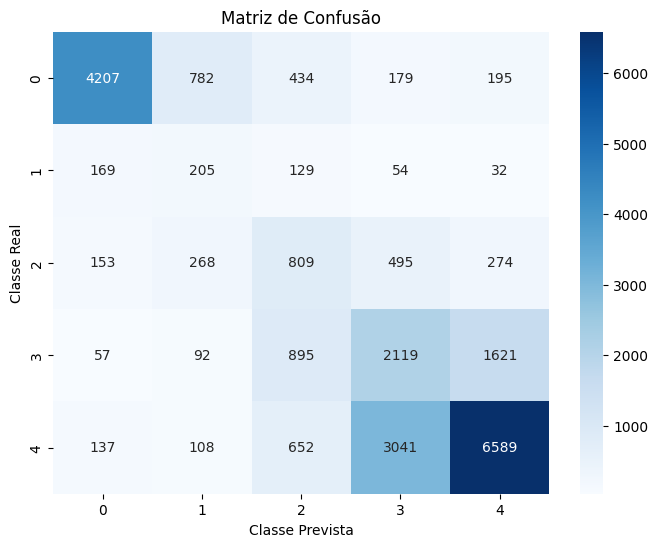

In [ ]:
plot_confusion_matrix(cm_log)

# 6 - Melhorando o modelo

## 6.1 - Usando o Class Weights

In [ ]:
# Adicionando a acuracia balanceada como driver da Regressão Logistica
classifier = LogisticRegression(max_iter = 500, class_weight='balanced')
classifier.fit(X_train_tfidf, y_train)

X_val_tfidf = vectorizer.transform(X_val)
y_pred = classifier.predict(X_val_tfidf)



In [ ]:
b_accuracy = balanced_accuracy_score(y_val, y_pred)
print('#------------------------------------------------------------#')
print("Balanced Accuracy:", b_accuracy)
print('#------------------------------------------------------------#')
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)
print('#------------------------------------------------------------#')
print(classification_report(y_val, y_pred))
print('#------------------------------------------------------------#')

#------------------------------------------------------------#
Balanced Accuracy: 0.5211442509222268
#------------------------------------------------------------#
Accuracy: 0.5329710909474573
#------------------------------------------------------------#
              precision    recall  f1-score   support

           1       0.78      0.72      0.75      3713
           2       0.25      0.51      0.34      1221
           3       0.31      0.40      0.35      2370
           4       0.45      0.39      0.42      4841
           5       0.68      0.58      0.63      6811

    accuracy                           0.53     18956
   macro avg       0.50      0.52      0.50     18956
weighted avg       0.57      0.53      0.54     18956

#------------------------------------------------------------#


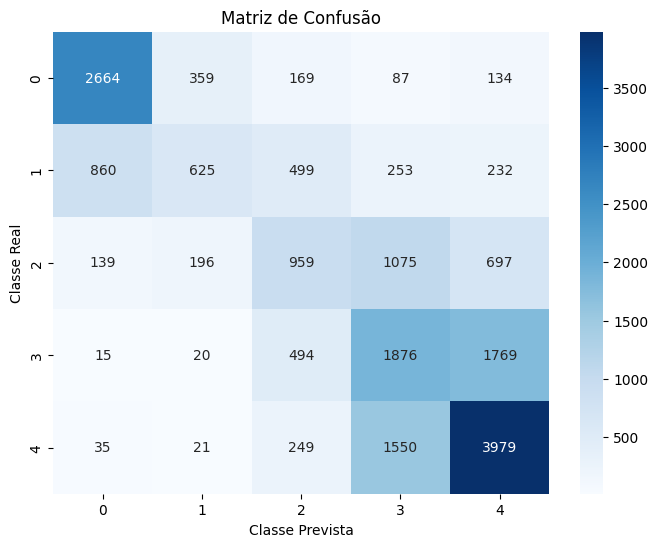

In [ ]:
cm_log_cw = confusion_matrix(y_pred,y_val)
plot_confusion_matrix(cm_log_cw)

## 6.2 - Grid Search da Regressão Logistica

In [ ]:
### Grid Search no modelo de Regressão Logistica
params = {'C': [0.001, 0.01, 0.1, 1],
          'tol': [0.0001, 0.001, 0.01]}
classifier = LogisticRegression(max_iter = 500, class_weight='balanced', n_jobs=-1, verbose=1)
gd = GridSearchCV(classifier,params, scoring = 'balanced_accuracy', verbose = 1, cv = 2)
gd.fit(X_train_tfidf, y_train)

Fitting 2 folds for each of 12 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

GridSearchCV(cv=2,
             estimator=LogisticRegression(class_weight='balanced', max_iter=500,
                                          n_jobs=-1, verbose=1),
             param_grid={'C': [0.001, 0.01, 0.1, 1],
                         'tol': [0.0001, 0.001, 0.01]},
             scoring='balanced_accuracy', verbose=1)

In [ ]:
print(gd.best_params_)
pd.DataFrame(gd.cv_results_).sort_values('mean_test_score', ascending = False).head(1)

{'C': 0.1, 'tol': 0.0001}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_tol,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
6,2.304824,0.007519,0.026562,0.00024,0.1,0.0001,"{'C': 0.1, 'tol': 0.0001}",0.527023,0.525805,0.526414,0.000609,1


In [ ]:
# Adicionando a acuracia balanceada como driver da Regressão Logistica
classifier = LogisticRegression(max_iter = 500, class_weight='balanced', **gd.best_params_)
classifier.fit(X_train_tfidf, y_train)

X_val_tfidf = vectorizer.transform(X_val)
y_pred = classifier.predict(X_val_tfidf)


In [ ]:
b_accuracy = balanced_accuracy_score(y_val, y_pred)
print('#------------------------------------------------------------#')
print("Balanced Accuracy:", b_accuracy)
print('#------------------------------------------------------------#')
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)
print('#------------------------------------------------------------#')
print(classification_report(y_val, y_pred))
print('#------------------------------------------------------------#')

#------------------------------------------------------------#
Balanced Accuracy: 0.5220121926049104
#------------------------------------------------------------#
Accuracy: 0.5302806499261448
#------------------------------------------------------------#
              precision    recall  f1-score   support

           1       0.77      0.72      0.74      3713
           2       0.25      0.53      0.34      1221
           3       0.32      0.41      0.36      2370
           4       0.45      0.38      0.41      4841
           5       0.68      0.58      0.63      6811

    accuracy                           0.53     18956
   macro avg       0.49      0.52      0.49     18956
weighted avg       0.57      0.53      0.54     18956

#------------------------------------------------------------#


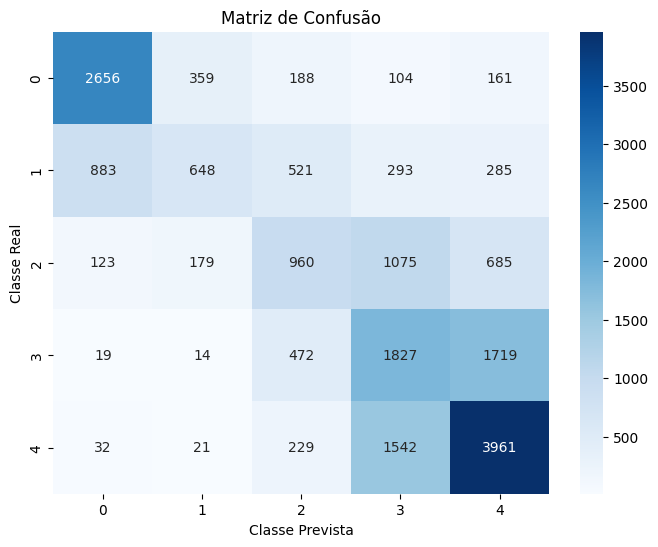

In [ ]:
cm_log_final = confusion_matrix(y_pred,y_val)
plot_confusion_matrix(cm_log_final)

## 6.3 -  Random Forest

In [ ]:
rf = RandomForestClassifier(n_jobs=-1, verbose=1, class_weight = 'balanced')
rf.fit(X_train_tfidf, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.1min finished


RandomForestClassifier(class_weight='balanced', n_jobs=-1, verbose=1)

In [ ]:
X_val_tfidf = vectorizer.transform(X_val)
y_pred = rf.predict(X_val_tfidf)

b_accuracy = balanced_accuracy_score(y_val, y_pred)
print('#------------------------------------------------------------#')
print("Balanced Accuracy:", b_accuracy)
print('#------------------------------------------------------------#')
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)
print('#------------------------------------------------------------#')
print(classification_report(y_val, y_pred))
print('#------------------------------------------------------------#')

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s


#------------------------------------------------------------#
Balanced Accuracy: 0.46775541915991
#------------------------------------------------------------#
Accuracy: 0.564095800801857
#------------------------------------------------------------#
              precision    recall  f1-score   support

           1       0.67      0.90      0.77      3713
           2       0.36      0.12      0.18      1221
           3       0.40      0.26      0.31      2370
           4       0.44      0.32      0.37      4841
           5       0.59      0.74      0.66      6811

    accuracy                           0.56     18956
   macro avg       0.49      0.47      0.46     18956
weighted avg       0.53      0.56      0.53     18956

#------------------------------------------------------------#
[[3335  707  426  240  262]
 [ 114  147   71   43   30]
 [  84  192  612  430  231]
 [  50   76  626 1558 1247]
 [ 130   99  635 2570 5041]]
#-----------------------------------------------------

[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.7s finished


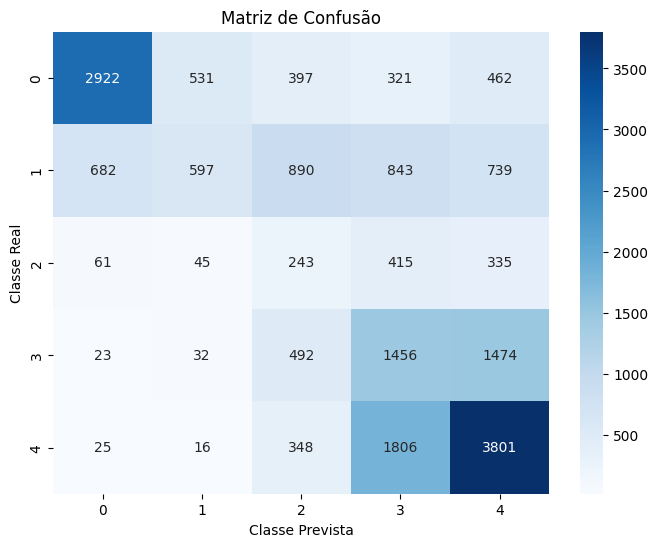

In [ ]:
cm_rf = confusion_matrix(y_pred,y_val)
plot_confusion_matrix(cm_rf)

### 6.3.1 - Grid Search no Random Forest

In [ ]:
### Grid Search no modelo de Random Forest
params = {'n_estimators': [100, 200, 400, 500],
          'max_depth': [None, 10, 50, 100]}
rf = RandomForestClassifier(n_jobs=-1, verbose=1, class_weight = 'balanced')
rf = GridSearchCV(rf,params, scoring = 'balanced_accuracy', verbose = 1, cv = 2)
rf.fit(X_train_tfidf, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 2 folds for each of 16 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.0min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   59.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 200 out 

GridSearchCV(cv=2,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, verbose=1),
             param_grid={'max_depth': [None, 10, 50, 100],
                         'n_estimators': [100, 200, 400, 500]},
             scoring='balanced_accuracy', verbose=1)

In [ ]:
print(rf.best_params_)
pd.DataFrame(rf.cv_results_).sort_values('mean_test_score', ascending = False).head(1)

{'max_depth': 50, 'n_estimators': 100}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
8,30.075829,0.80323,0.718911,0.006267,50,100,"{'max_depth': 50, 'n_estimators': 100}",0.488101,0.489374,0.488738,0.000636,1


In [ ]:
rf = RandomForestClassifier(n_jobs=-1, verbose=1, class_weight = 'balanced', **rf.best_params_)
rf.fit(X_train_tfidf, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished


RandomForestClassifier(class_weight='balanced', max_depth=50, n_jobs=-1,
                       verbose=1)

In [ ]:
X_val_tfidf = vectorizer.transform(X_val)
y_pred = rf.predict(X_val_tfidf)

b_accuracy = balanced_accuracy_score(y_val, y_pred)
print('#------------------------------------------------------------#')
print("Balanced Accuracy:", b_accuracy)
print('#------------------------------------------------------------#')
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)
print('#------------------------------------------------------------#')
print(classification_report(y_val, y_pred))
print('#------------------------------------------------------------#')


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s


#------------------------------------------------------------#
Balanced Accuracy: 0.49468974377838204
#------------------------------------------------------------#
Accuracy: 0.5442076387423507
#------------------------------------------------------------#
              precision    recall  f1-score   support

           1       0.70      0.83      0.76      3713
           2       0.25      0.30      0.27      1221
           3       0.33      0.36      0.34      2370
           4       0.44      0.35      0.39      4841
           5       0.64      0.63      0.64      6811

    accuracy                           0.54     18956
   macro avg       0.47      0.49      0.48     18956
weighted avg       0.54      0.54      0.54     18956

#------------------------------------------------------------#
[[3093  559  321  201  225]
 [ 414  363  261  185  208]
 [ 129  218  856  826  583]
 [  32   45  569 1681 1472]
 [  45   36  363 1948 4323]]
#-------------------------------------------------

[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.7s finished


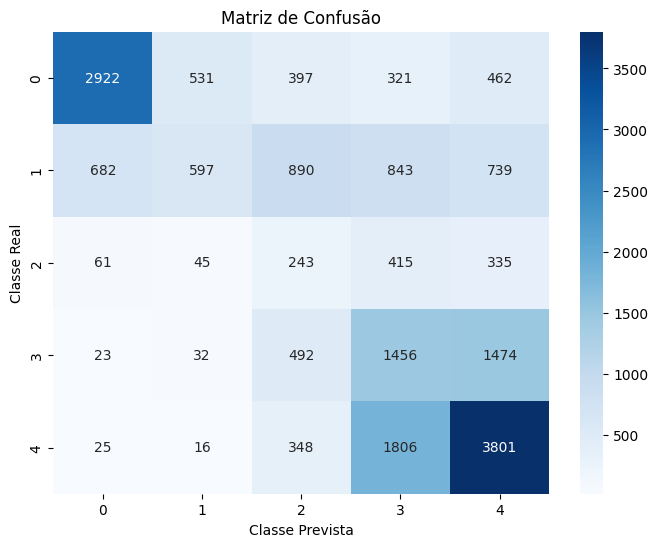

In [ ]:
cm_rf_bp = confusion_matrix(y_pred,y_val)
plot_confusion_matrix(cm_rf_bp)

## 6.4 - Naive Bayes Models

### 6.4.1 - Multinomial Naive Bayes

In [ ]:
MNB = MultinomialNB()
MNB.fit(X_train_tfidf, y_train)

MultinomialNB()

In [ ]:
X_val_tfidf = vectorizer.transform(X_val)
y_pred = MNB.predict(X_val_tfidf)

b_accuracy = balanced_accuracy_score(y_val, y_pred)
print('#------------------------------------------------------------#')
print("Balanced Accuracy:", b_accuracy)
print('#------------------------------------------------------------#')
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)
print('#------------------------------------------------------------#')
print(classification_report(y_val, y_pred))
print('#------------------------------------------------------------#')


#------------------------------------------------------------#
Balanced Accuracy: 0.44965102382396527
#------------------------------------------------------------#
Accuracy: 0.5611943447984807
#------------------------------------------------------------#
              precision    recall  f1-score   support

           1       0.66      0.88      0.76      3713
           2       0.32      0.07      0.12      1221
           3       0.36      0.23      0.28      2370
           4       0.44      0.26      0.32      4841
           5       0.58      0.80      0.68      6811

    accuracy                           0.56     18956
   macro avg       0.47      0.45      0.43     18956
weighted avg       0.52      0.56      0.52     18956

#------------------------------------------------------------#


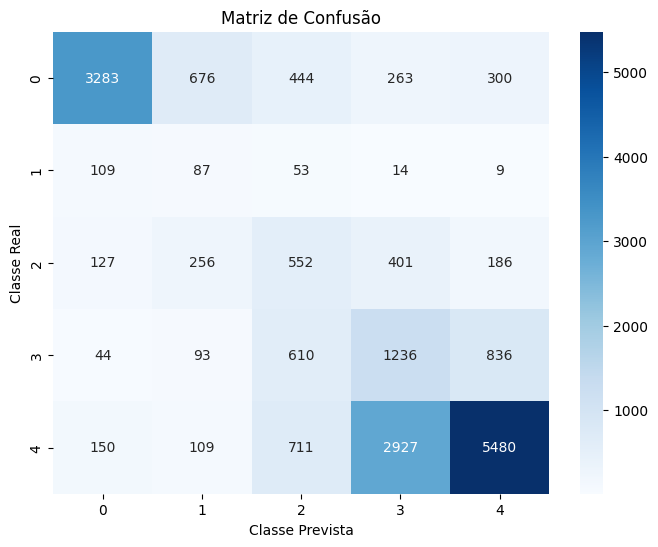

In [ ]:
cm_mnb = confusion_matrix(y_pred,y_val)
plot_confusion_matrix(cm_mnb)

### 7.4.2 Gaussian Naive Bayes

Abortado, precisa de uma matriz densa e vai consumir muita memoria do computador

In [ ]:
GNB = GaussianNB()
GNB.fit(X_train_tfidf.toarray(), y_train)

GaussianNB()

In [ ]:
X_val_tfidf = vectorizer.transform(X_val)
y_pred = GNB.predict(X_val_tfidf.toarray())

b_accuracy = balanced_accuracy_score(y_val, y_pred)
print('#------------------------------------------------------------#')
print("Balanced Accuracy:", b_accuracy)
print('#------------------------------------------------------------#')
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)
print('#------------------------------------------------------------#')
print(classification_report(y_val, y_pred))
print('#------------------------------------------------------------#')

#------------------------------------------------------------#
Balanced Accuracy: 0.44745439788286834
#------------------------------------------------------------#
Accuracy: 0.4757860308081874
#------------------------------------------------------------#
              precision    recall  f1-score   support

           1       0.63      0.79      0.70      3713
           2       0.16      0.49      0.24      1221
           3       0.22      0.10      0.14      2370
           4       0.42      0.30      0.35      4841
           5       0.63      0.56      0.59      6811

    accuracy                           0.48     18956
   macro avg       0.41      0.45      0.40     18956
weighted avg       0.50      0.48      0.47     18956

#------------------------------------------------------------#


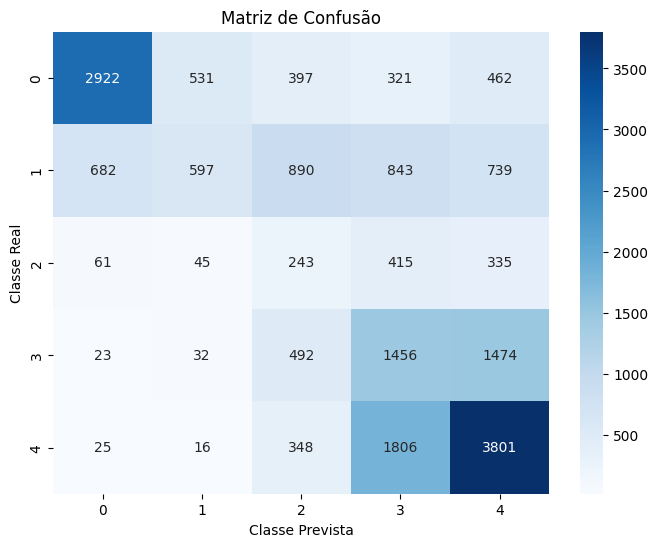

In [ ]:
cm_gnb = confusion_matrix(y_pred,y_val)
plot_confusion_matrix(cm_gnb)

## 6.5 - XGBoost Classifier

In [ ]:
xgb_classifier = xgb.XGBClassifier(n_jobs = -1, n_estimators = 100)

In [ ]:
xgb_classifier.fit(X_train_tfidf, y_train)

XGBClassifier(n_jobs=-1, objective='multi:softprob')

In [ ]:
X_val_tfidf = vectorizer.transform(X_val)
y_pred = xgb_classifier.predict(X_val_tfidf)

b_accuracy = balanced_accuracy_score(y_val, y_pred)
print('#------------------------------------------------------------#')
print("Balanced Accuracy:", b_accuracy)
print('#------------------------------------------------------------#')
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)
print('#------------------------------------------------------------#')
print(classification_report(y_val, y_pred))
print('#------------------------------------------------------------#')

#------------------------------------------------------------#
Balanced Accuracy: 0.40396096991251706
#------------------------------------------------------------#
Accuracy: 0.5330238446929731
#------------------------------------------------------------#
              precision    recall  f1-score   support

           1       0.61      0.81      0.70      3713
           2       0.42      0.01      0.02      1221
           3       0.43      0.12      0.18      2370
           4       0.42      0.28      0.33      4841
           5       0.54      0.80      0.64      6811

    accuracy                           0.53     18956
   macro avg       0.48      0.40      0.38     18956
weighted avg       0.50      0.53      0.48     18956

#------------------------------------------------------------#


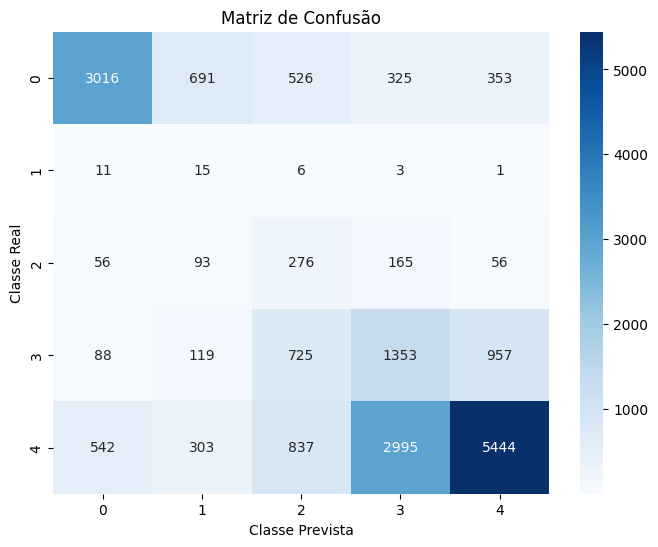

In [ ]:
cm_xgb = confusion_matrix(y_pred,y_val)
plot_confusion_matrix(cm_xgb)

## 6.6 - Transformers

In [ ]:
df_transformer = df.copy()

In [ ]:
df_transformer['New_target'] = df_transformer['overall_rating']  - 1

In [ ]:
df_transformer.rename(columns={'New_target':'target','review_text':'text'},inplace=True)
df_transformer = df_transformer[['text','target']]

In [ ]:
# Separação das bases de treino, teste e validação

#Teste
test = df_transformer.sample(frac=0.1,random_state=42)

#Treino e Validação
df_transformer = df_transformer.drop(test.index)
train, val = train_test_split(df_transformer,test_size=0.2,random_state=42)
print(train.shape, val.shape, test.shape)

(85302, 2) (21326, 2) (11848, 2)


In [ ]:
# Transformando em DataSet
dataset_train = Dataset.from_pandas(train,preserve_index=False)
dataset_val = Dataset.from_pandas(val,preserve_index=False)

In [ ]:
dataset_train, dataset_val

(Dataset({
     features: ['text', 'target'],
     num_rows: 85302
 }),
 Dataset({
     features: ['text', 'target'],
     num_rows: 21326
 }))

In [ ]:
model_name = 'neuralmind/bert-base-portuguese-cased'
tokenizer = AutoTokenizer.from_pretrained(model_name,do_lower_case=False)

In [ ]:
#limitando o número de Caracteres
def tokenize_function(sample):
    return tokenizer(sample['text'],truncation=True,max_length=512)

tokenized_dataset_train = dataset_train.map(tokenize_function)
tokenized_dataset_val = dataset_val.map(tokenize_function)

Map:   0%|          | 0/85302 [00:00<?, ? examples/s]

Map:   0%|          | 0/21326 [00:00<?, ? examples/s]

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer,return_tensors='tf')

In [ ]:
tf_train_dataset = tokenized_dataset_train.to_tf_dataset(
    columns=['attention_mask','input_ids','token_type_ids'],
    label_cols=['target'],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8
)

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:385: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [ ]:
tf_val_dataset = tokenized_dataset_val.to_tf_dataset(
    columns=['attention_mask','input_ids','token_type_ids'],
    label_cols=['target'],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=8
)

In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained(model_name,num_labels=5)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(
    optimizer = opt,
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy'],
)

In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108923136 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  3845      
                                                                 
Total params: 108,926,981
Trainable params: 108,926,981
Non-trainable params: 0
_________________________________________________________________


In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# Balanceamento de pesos
df_contagem = train['target'].value_counts().reset_index()
df_contagem['weights'] = len(train)/df_contagem['target']


In [ ]:
df_contagem

,index,target,weights
0,4,31145,2.738867
1,3,21620,3.945513
2,0,16458,5.183011
3,2,10733,7.947638
4,1,5346,15.956229


In [ ]:
class_weights_dict = dict(zip(df_contagem['index'], df_contagem['weights']))
class_weights_dict

{4: 2.738866591748274,
 3: 3.945513413506013,
 0: 5.183011301494714,
 2: 7.947638125407622,
 1: 15.956228956228957}

In [ ]:
# Fitando o modelo
model.fit(tf_train_dataset, validation_data=tf_val_dataset,epochs=2,class_weight=class_weights_dict)

Epoch 1/2
10663/10663 [==============================] - 2352s 212ms/step - loss: 4.8422 - accuracy: 0.5753 - val_loss: 0.9003 - val_accuracy: 0.6000
Epoch 2/2
10663/10663 [==============================] - 2137s 200ms/step - loss: 4.2575 - accuracy: 0.6161 - val_loss: 0.8945 - val_accuracy: 0.6050


In [ ]:
preds = model.predict(tf_val_dataset,verbose=1)

2666/2666 [==============================] - 201s 74ms/step


In [ ]:
predict_proba = tf.nn.softmax(preds['logits']).numpy()
y_pred = np.argmax(predict_proba, axis=1)

In [ ]:
y_true = val['target']

In [ ]:
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

b_accuracy = balanced_accuracy_score(y_true,y_pred)
print("Balanced Accuracy:",b_accuracy)

Accuracy: 0.6049892150426709
Balanced Accuracy: 0.5966422409533143


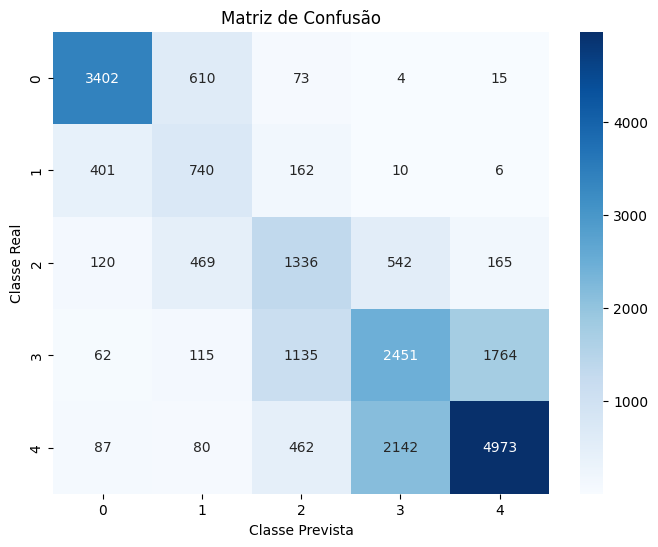

In [ ]:
cm_transformer = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm_transformer)